# Módulo 2: Implementación de un modelo de deep learning

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Input, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import tensorflow_hub as hub

In [9]:
data_directory = pathlib.Path('./pizza_not_pizza/')
class_names = [item.name for item in data_directory.glob('*')][:2]
print(class_names)

['not_pizza', 'pizza']


In [10]:
# Cargar los datos
data_gen = ImageDataGenerator(rescale = 1/255., validation_split = 0.2)

train_data = data_gen.flow_from_directory("./pizza_not_pizza/", 
                                          target_size = (224, 224), 
                                          batch_size = 32,
                                          subset = 'training',
                                          class_mode = 'binary')
val_data = data_gen.flow_from_directory("./pizza_not_pizza/", 
                                        target_size = (224, 224), 
                                        batch_size = 32,
                                        subset = 'validation',
                                        class_mode = 'binary')

Found 1573 images belonging to 2 classes.
Found 392 images belonging to 2 classes.


In [12]:
def plot_random_images(num):
    
    images, labels = train_data.next()
    labels = labels.astype('int32')
    i = 1

    plt.figure(figsize = (15, 15))
    
    for image, label in zip(images, labels):
        plt.subplot(5, 5, i)
        plt.imshow(image)
        plt.title(class_names[label])
        plt.axis('off')
        i += 1
        if i == num+1:
            break

    plt.tight_layout()       
    plt.show()

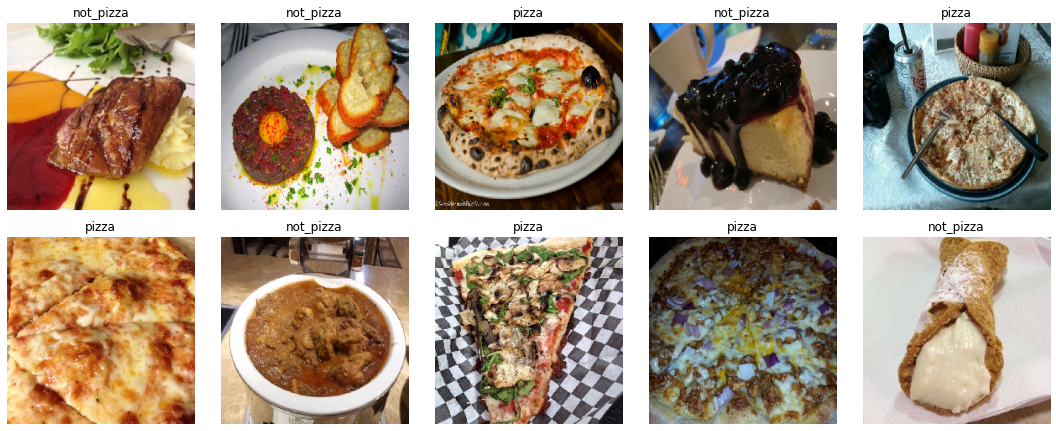

In [13]:
plot_random_images(10)

## Modelo 1

In [14]:
model_1 = Sequential([
    Input(shape = (224, 224, 3)), 
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    Conv2D(filters = 32, kernel_size = 2, padding = 'valid', activation = 'relu'),
    Flatten(),
    Dense(1, activation = 'sigmoid')
])

In [15]:
model_1.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

In [16]:
history_1 = model_1.fit(train_data,
                        epochs= 10,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/10
50/50 [==============================] - 41s 813ms/step - loss: 1.6667 - accuracy: 0.5175 - val_loss: 0.6878 - val_accuracy: 0.5179
Epoch 2/10
50/50 [==============================] - 42s 841ms/step - loss: 0.6209 - accuracy: 0.6815 - val_loss: 0.7682 - val_accuracy: 0.5026
Epoch 3/10
50/50 [==============================] - 36s 709ms/step - loss: 0.3968 - accuracy: 0.8404 - val_loss: 0.6249 - val_accuracy: 0.6786
Epoch 4/10
50/50 [==============================] - 36s 723ms/step - loss: 0.1695 - accuracy: 0.9580 - val_loss: 0.7235 - val_accuracy: 0.6531
Epoch 5/10
50/50 [==============================] - 37s 739ms/step - loss: 0.0632 - accuracy: 0.9898 - val_loss: 0.7801 - val_accuracy: 0.6556
Epoch 6/10
50/50 [==============================] - 36s 724ms/step - loss: 0.0177 - accuracy: 0.9994 - val_loss: 0.8404 - val_accuracy: 0.6837
Epoch 7/10
50/50 [==============================] - 35s 699ms/step - loss: 0.0063 - accuracy: 1.0000 - val_loss: 0.8375 - val_accuracy: 0.6786

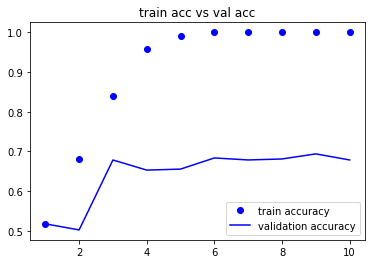

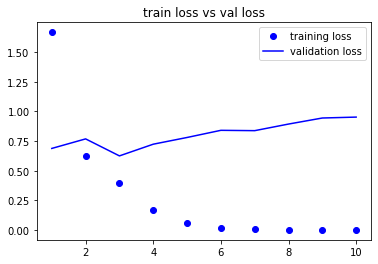

In [17]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [18]:
model_1.evaluate(val_data)

13/13 [==============================] - 2s 142ms/step - loss: 0.9518 - accuracy: 0.6786


[0.9517784118652344, 0.6785714030265808]

In [19]:
train_data.class_indices

{'not_pizza': 0, 'pizza': 1}

In [20]:
img = cv2.imread('./test/pizza.jpg')
img = cv2.resize(img,(224,224))
img = img/255.0
img = img.reshape(-1,224,224,3)

np.round(model_1.predict(img)).argmax(axis=1)

1/1 [==============================] - 0s 75ms/step


array([0], dtype=int64)

## Modelo 2

In [21]:
url = 'https://tfhub.dev/google/efficientnet/b7/feature-vector/1'

feature_extractor_layer = hub.KerasLayer(url,
                                         trainable=False,
                                         input_shape=(224, 224, 3))

In [22]:
model_2 = Sequential([
    feature_extractor_layer,
    Dense(1, activation = 'sigmoid')
])

model_2.compile(loss = BinaryCrossentropy(),
                optimizer = Adam(),
                metrics = ['accuracy'])

history_2 = model_2.fit(train_data,
                        epochs= 10,
                        steps_per_epoch = len(train_data),
                        validation_data = val_data,
                        validation_steps = len(val_data))

Epoch 1/10
50/50 [==============================] - 318s 6s/step - loss: 0.2595 - accuracy: 0.9313 - val_loss: 0.1499 - val_accuracy: 0.9592
Epoch 2/10
50/50 [==============================] - 310s 6s/step - loss: 0.1229 - accuracy: 0.9587 - val_loss: 0.1172 - val_accuracy: 0.9566
Epoch 3/10
50/50 [==============================] - 311s 6s/step - loss: 0.1037 - accuracy: 0.9663 - val_loss: 0.1120 - val_accuracy: 0.9617
Epoch 4/10
50/50 [==============================] - 305s 6s/step - loss: 0.0928 - accuracy: 0.9682 - val_loss: 0.1012 - val_accuracy: 0.9617
Epoch 5/10
50/50 [==============================] - 292s 6s/step - loss: 0.0853 - accuracy: 0.9688 - val_loss: 0.0952 - val_accuracy: 0.9668
Epoch 6/10
50/50 [==============================] - 323s 6s/step - loss: 0.0796 - accuracy: 0.9727 - val_loss: 0.0934 - val_accuracy: 0.9668
Epoch 7/10
50/50 [==============================] - 320s 6s/step - loss: 0.0750 - accuracy: 0.9758 - val_loss: 0.0925 - val_accuracy: 0.9668
Epoch 8/10
50

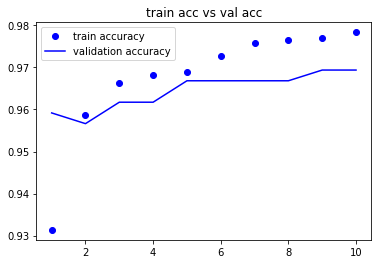

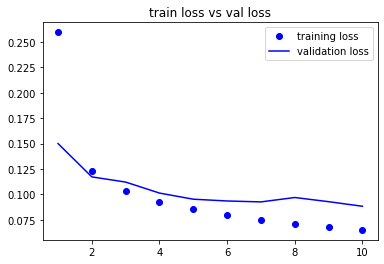

In [23]:
acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']
loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs,acc,'bo',label='train accuracy')
plt.plot(epochs,val_acc, 'b', label='validation accuracy')
plt.title('train acc vs val acc')
plt.legend()

plt.figure()

plt.plot(epochs,loss, 'bo', label ='training loss')
plt.plot(epochs,val_loss, 'b', label = 'validation loss')
plt.title('train loss vs val loss')
plt.legend()

plt.show()

In [ ]:
model_2.save("model.h5")

In [24]:
model_2.evaluate(val_data)

13/13 [==============================] - 62s 5s/step - loss: 0.0882 - accuracy: 0.9694


[0.08824501186609268, 0.9693877696990967]

In [25]:
val_data.class_indices

{'not_pizza': 0, 'pizza': 1}

In [26]:
def predict(dir):
    # img = cv2.imread('./test/pizza.jpg')
    img = cv2.imread(dir)
    img = cv2.resize(img,(224,224))
    img = img/255.0
    img = img.reshape(-1,224,224,3)
    
    if(int(np.round(model_2.predict(img))) == 1):
        print("Es pizza")
    else:
        print("No es pizza")

In [29]:
predict('./test/pizza.png')

1/1 [==============================] - 2s 2s/step
Es pizza
